In [ ]:
# pip3 install --upgrade networkx

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

In [2]:
HUB_DEGREE = 250
DATA_DIR = 'analysing_anonymity/'

user_edges_file = DATA_DIR + 'user_edges_2011-07-13.txt'
user_vertices_file = DATA_DIR + 'user_vertices_2011-07-13.txt'

In [3]:
with open(user_vertices_file, 'r') as f:
    vertices_and_addresses = f.read().splitlines()
with open(user_edges_file, 'r') as f:
    transactions = f.read().splitlines()
vertex2keys = {(idx+1): len(addresses.split('\t')) for idx, addresses in enumerate(vertices_and_addresses)}

In [4]:
# transactions = transactions[:50000]

In [5]:
transactions_list = [t.split('\t') for t in transactions]
transactions_df = pd.DataFrame(transactions_list, columns=['sender', 'receiver', 'BTC', 'date'])
transactions_df.head()

,sender,receiver,BTC,date
0,1,5994,8.94,2011-07-04-09-05-56
1,905914,20572,0.01,2011-06-23-19-10-01
2,905914,622803,220.07592886,2011-06-23-19-10-01
3,823336,118969,2.12,2011-05-16-01-58-01
4,823336,330686,0.56210609,2011-05-16-01-58-01


In [6]:
transactions_df[['sender', 'receiver']] = transactions_df[['sender', 'receiver']].astype('int')
transactions_df['BTC'] = transactions_df['BTC'].astype('float')

In [7]:
g = nx.from_pandas_edgelist(transactions_df, 'sender', 'receiver', ['BTC', 'date'], create_using=nx.MultiDiGraph())
# layout = nx.spring_layout(g,iterations=50)
# nx.draw(g, layout)

In [8]:
nodes_to_include = []
for node in g.nodes():
    degree = g.in_degree(node) + g.out_degree(node)
#     print(node, g.in_degree(node) + g.out_degree(node))
    if degree >= HUB_DEGREE:
        nodes_to_include.append(node)
print(f'Number of nodes to include: {len(nodes_to_include)}')
# removing non-hub nodes makes the graph sparse and the hubs lose their characteristics
# lets 
# for node in nodes_to_exclude:
#     g.remove_node(node)

Number of nodes to include: 554


In [9]:
def get_degrees(node, g):
    
    in_degree = g.in_degree(node)
    out_degree = g.out_degree(node)
    degree = in_degree + out_degree
    
    return in_degree, out_degree, degree

def get_features(node, g):
    features = {}
    
    in_degree, out_degree, degree = get_degrees(node, g)

    features['in_degree'] = in_degree
    features['out_degree'] = out_degree
    features['degree'] = degree
#     features['num_public_keys'] = vertex2keys[node]
    
    children_in_degrees = []
    children_out_degrees = []
    children_degrees = []

    in_nodes = list(g.predecessors(node))
    out_nodes = list(g.successors(node))
    
#     features['unique_in_degree'] = len(in_nodes)
#     features['unique_out_degree'] = len(out_nodes)
    
    in_trasaction = []
    out_transaction = []
    _transaction = []

    features['mean_in_BTC'] = 0
    features['mean_out_BTC'] = 0
    features['mean_BTC'] = 0
    features['var_in_BTC'] = 0
    features['var_out_BTC'] = 0
    features['var_BTC'] = 0
    
    features['children_mean_in_degree'] = 0
    features['children_mean_out_degree'] = 0
    features['children_mean_degree'] = 0
    features['children_var_in_degree'] = 0
    features['children_var_out_degree'] = 0
    features['children_var_degree'] = 0
    
    
    
    if len(in_nodes):
        for in_node in in_nodes:
            for _, transaction in g[in_node][node].items():
                in_trasaction.append(transaction['BTC'])
#         print(in_trasaction)
        features['mean_in_BTC'] = np.mean(in_trasaction)
        features['var_in_BTC'] = np.var(in_trasaction)
        _transaction += in_trasaction

    if len(out_nodes):
        for out_node in out_nodes:
            c_in_degree, c_out_degree, c_degree = get_degrees(out_node, g)
            children_in_degrees.append(c_in_degree)
            children_out_degrees.append(c_out_degree)
            children_degrees.append(c_degree)
            for _, transaction in g[node][out_node].items():
                out_transaction.append(transaction['BTC'])
        
        features['mean_out_BTC'] = np.mean(out_transaction)
        features['var_out_BTC'] = np.var(out_transaction)
        
        features['children_mean_in_degree'] = np.mean(children_in_degrees)
        features['children_mean_out_degree'] = np.mean(children_out_degrees)
        features['children_mean_degree'] = np.mean(children_degrees)
        features['children_var_in_degree'] = np.var(children_in_degrees)
        features['children_var_out_degree'] = np.var(children_out_degrees)
        features['children_var_degree'] = np.var(children_degrees)
    
        _transaction += out_transaction
    
    if transaction:
        features['mean_BTC'] = np.mean(_transaction)
        features['var_BTC'] = np.var(_transaction)
    
    
    
#     features['balance'] = np.sum(in_trasaction) - np.sum(out_transaction)
    return pd.Series(list(features.values()))
    

In [10]:
nodes_df = pd.DataFrame(nodes_to_include, columns=['Node'])

In [11]:
features = ['in_degree', 'out_degree', 'degree', \
#             'unique_in_degree', 'unique_out_degree', 'balance'
            'mean_in_BTC', 'mean_out_BTC', 'mean_BTC',\
            'var_in_BTC', 'var_out_BTC', 'var_BTC',\
            'children_mean_in_degree', 'children_mean_out_degree',\
            'children_mean_degree', 'children_var_in_degree',\
            'children_var_out_degree', 'children_var_degree' ]

In [12]:
nodes_df.head()

,Node
0,1
1,2
2,2909
3,1743
4,260244


In [13]:
nodes_df[features] = nodes_df.apply(lambda row: get_features(row['Node'], g), axis=1)

In [14]:
nodes_df.head(15)

,Node,in_degree,out_degree,degree,mean_in_BTC,mean_out_BTC,mean_BTC,var_in_BTC,var_out_BTC,var_BTC,children_mean_in_degree,children_mean_out_degree,children_mean_degree,children_var_in_degree,children_var_out_degree,children_var_degree
0,1,204.0,105.0,309.0,21.240342,41.236190,28.035048,4.333556e+02,4.559610e+04,1.586962e+04,1667.000000,357.666667,2024.666667,1.209854e+08,5.458648e+06,1.778407e+08
1,2,3305.0,2910.0,6215.0,0.471159,0.543876,0.505207,5.467018e+00,6.948765e+00,6.162121e+00,169.939560,44.893773,214.833333,1.019868e+07,4.745991e+05,1.503124e+07
2,2909,347.0,173.0,520.0,212.289222,425.805549,283.324462,7.475791e+05,1.976617e+06,1.166592e+06,845.196262,224.504673,1069.700935,5.218603e+07,2.630085e+06,7.759352e+07
3,1743,845.0,52.0,897.0,0.098415,1.556538,0.182944,8.232848e-02,4.781843e+01,2.965747e+00,2984.062500,852.906250,3836.968750,1.688996e+08,8.549091e+06,2.508892e+08
4,260244,4966.0,5252.0,10218.0,0.010000,0.056243,0.033769,3.009266e-36,1.645592e-01,8.511677e-02,372.224000,101.080000,473.304000,2.224790e+07,1.110576e+06,3.296380e+07
5,23,74628.0,15855.0,90483.0,12.637562,59.490309,20.847395,1.085447e+05,6.064186e+05,1.961026e+05,28.003850,12.007020,40.010870,6.895520e+05,5.843419e+04,1.083859e+06
6,3463,1152.0,2093.0,3245.0,61.561319,33.906439,43.724135,2.479134e+04,1.944738e+04,2.151964e+04,108.687637,147.791514,256.479151,4.134444e+06,2.102923e+07,2.825974e+07
7,8064,202.0,85.0,287.0,15.082837,35.735094,21.199359,1.663353e+02,3.973045e+03,1.382666e+03,1486.641509,389.849057,1876.490566,1.030277e+08,4.925253e+06,1.518945e+08
8,2226,1188.0,97.0,1285.0,1.390194,17.012784,2.569486,5.154817e+02,9.242408e+03,1.191279e+03,334.877551,196.469388,531.346939,2.360932e+06,9.728129e+05,6.343505e+06
9,767,244.0,322.0,566.0,0.203678,0.130509,0.162052,5.644987e-02,3.467739e-02,4.537641e-02,107.150000,68.690000,175.840000,1.045492e+06,4.004368e+05,2.739532e+06


In [15]:
nodes_df.to_csv('features.csv', index=False)

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = nodes_df[features].values
X_scaled = scaler.fit_transform(X)
print(X_scaled)


[[0.00273356 0.00062186 0.00033886 ... 0.08690088 0.02223832 0.08689706]
 [0.04428633 0.01723433 0.03425936 ... 0.00732546 0.0019335  0.00734461]
 [0.00464973 0.00102458 0.00155072 ... 0.03748397 0.01071486 0.03791399]
 ...
 [0.         0.00318036 0.00164835 ... 0.00787119 0.00291865 0.00806195]
 [0.         0.00262365 0.00110848 ... 0.0094415  0.00349954 0.00966935]
 [0.         0.00207878 0.00058008 ... 0.01216468 0.00464875 0.01254042]]


Text(0.5, 1.0, 'Elbow Method For Optimal k')

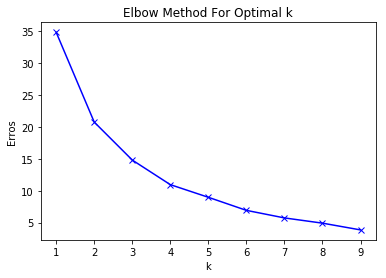

In [17]:
# https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
from sklearn.cluster import KMeans
error = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_scaled)
    error.append(km.inertia_)

plt.plot(K, error, 'bx-')
plt.xlabel('k')
plt.ylabel('Erros')
plt.title('Elbow Method For Optimal k')

In [18]:
km = KMeans(n_clusters=5)
km = km.fit(X_scaled)
labels = km.predict(X_scaled)
# print(labels)
nodes_df['cluster'] = labels

In [19]:
nodes_df.head()

,Node,in_degree,out_degree,degree,mean_in_BTC,mean_out_BTC,mean_BTC,var_in_BTC,var_out_BTC,var_BTC,children_mean_in_degree,children_mean_out_degree,children_mean_degree,children_var_in_degree,children_var_out_degree,children_var_degree,cluster
0,1,204.0,105.0,309.0,21.240342,41.236190,28.035048,4.333556e+02,4.559610e+04,1.586962e+04,1667.000000,357.666667,2024.666667,1.209854e+08,5.458648e+06,1.778407e+08,3
1,2,3305.0,2910.0,6215.0,0.471159,0.543876,0.505207,5.467018e+00,6.948765e+00,6.162121e+00,169.939560,44.893773,214.833333,1.019868e+07,4.745991e+05,1.503124e+07,3
2,2909,347.0,173.0,520.0,212.289222,425.805549,283.324462,7.475791e+05,1.976617e+06,1.166592e+06,845.196262,224.504673,1069.700935,5.218603e+07,2.630085e+06,7.759352e+07,3
3,1743,845.0,52.0,897.0,0.098415,1.556538,0.182944,8.232848e-02,4.781843e+01,2.965747e+00,2984.062500,852.906250,3836.968750,1.688996e+08,8.549091e+06,2.508892e+08,4
4,260244,4966.0,5252.0,10218.0,0.010000,0.056243,0.033769,3.009266e-36,1.645592e-01,8.511677e-02,372.224000,101.080000,473.304000,2.224790e+07,1.110576e+06,3.296380e+07,3


In [20]:
# https://stackoverflow.com/questions/47250670/histogram-color-by-class
def group_and_plot_hist(df, col_to_group, labels_col, bins):
    _, edges = np.histogram(df[col_to_group], bins=bins)
    histdata = []; labels=[]
    for n, group in df.groupby(labels_col):
        histdata.append(np.histogram(group[col_to_group], bins=edges)[0])
        labels.append(n)

    hist = np.array(histdata) 
    histcum = np.cumsum(hist,axis=0)

    plt.bar(edges[:-1],hist[0,:], width=np.diff(edges)[0],
                label=labels[0], align="edge")

    for i in range(1,len(hist)):
        plt.bar(edges[:-1],hist[i,:], width=np.diff(edges)[0],
                bottom=histcum[i-1,:],label=labels[i], align="edge")
    
    plt.xlabel(col_to_group)
    plt.ylabel('Hub Count')
    plt.legend(title="cluster")
    plt.show()

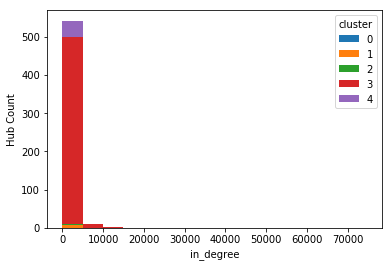

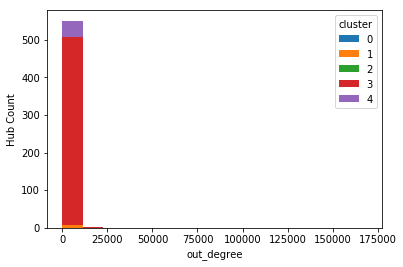

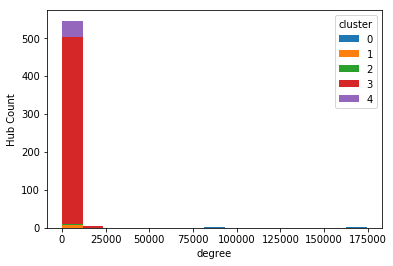

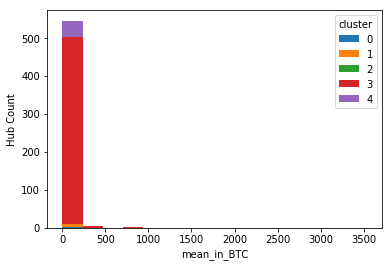

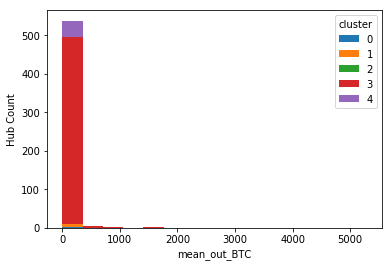

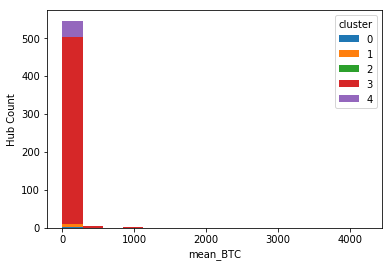

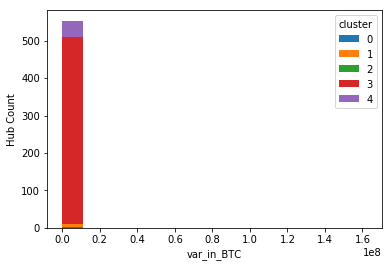

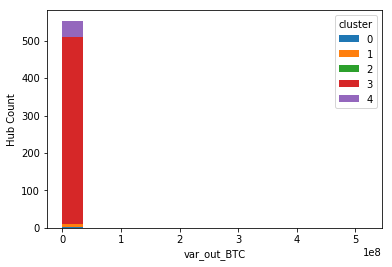

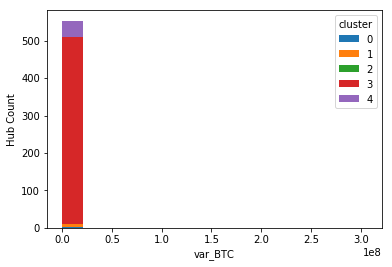

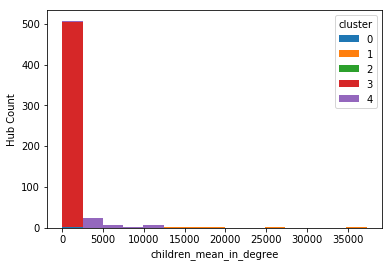

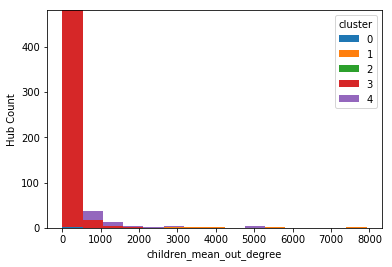

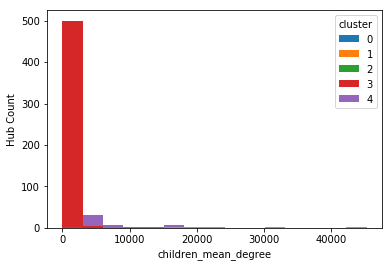

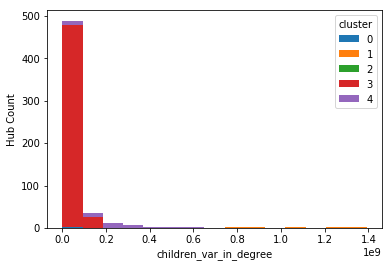

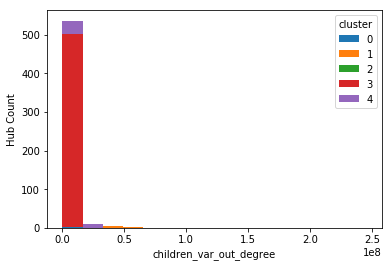

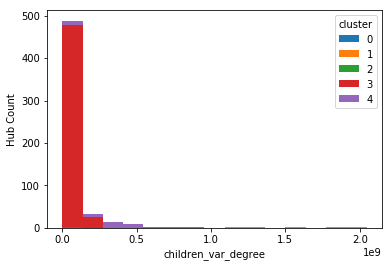

In [21]:
for feature in features:
    group_and_plot_hist(nodes_df, feature, "cluster", 15)

In [22]:
nodes_df.to_csv('processed_nodes.csv', index=False)